<a href="https://colab.research.google.com/github/Sera91/numerical-analysis-2021-2022/blob/main/Final_project_2021_2022_DiGioia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import scipy 
import scipy.linalg
import pandas as pd

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [27]:
def finDif(omega,f,n,bc):
    """
    This function 
    takes as input:
      -omega= domain interval
      -f = forcing function
      -n = number of discretization points
      -bc = boundary conditions
    returns:
      A = matrix on the lhs of the equation 'Ax=b'
      b = vector on the rhs
    """
    assert n>1
    assert omega[1]>omega[0]
    h   = (omega[1] - omega[0]) / (n-1)
    #print("h", h)
    ood = ones((n-2,))     #off-off diagonal elements
    od  = -16*ones((n-1,)) #off-diagonal terms
    d   = 30*ones((n,))    #diagonal terms 
    A   = (diag(ood,-2) + diag(od,-1) + diag(d,0) + diag(od,+1) + diag(ood,+2))/(12.0*pow(h,2))

    #print(A)

    x= linspace(omega[0],omega[1],n)
    b= f(x)  #forcing term on the right-hand side

    #APPLYING BOUNDARY CONDITIONS    
    # Change first row/column of the matrix A
    A[0,:] = 0
    A[:,0] = 0

    # Change last row/column of the matrix A
    A[-1,:] = 0
    A[:,-1] = 0
     

    A[0,0] = A[-1,-1] = 1

    #Change first term of b
    b[0] = bc[0]

    
    #Change last term of b
    b[-1] = bc[1]
  
    
    
    return A, b

Call the function using:

In [3]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega,f, n, bc)
#print(A)



Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

**LU factorization**

In [4]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U


L, U = LU(A)
#print(L)


**Cholesky decomposition**

For symmetric and positive defined matrices, the Cholesky decomposition may be preferred respect to the LU factorization, since it reduces the number of flops for computing the LU decomposition by a factor of 2.

The Cholesky decomposition seeks an upper triangular matrix H (with all positive elements on the diagonal) such that
A=HTH

An implementation of the Cholesky decomposition is provided in the following function. 

In [5]:
def cholesky(A):
    A = A.copy()
    #print(A)
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - (A[j:N,k]*A[j,k])
            
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i] 
    return x

In [7]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)
        
    x[-1] = rhs[-1]/U[-1,-1]
    
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, (i+1):N], x[(i+1):N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

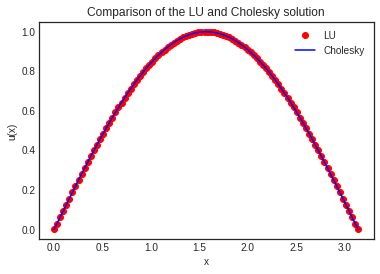

In [31]:

y_LU = L_solve(L,b)
u_LU = U_solve(U,y_LU)

y_CH = L_solve(HT,b)
u_CH = U_solve(H,y_CH)

x=linspace(0,pi,n)

plt.title('Comparison of the LU and Cholesky solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.plot(x,u_LU,'ro', label='LU' )
plt.plot(x,u_CH,'b', label='Cholesky')
plt.legend(loc='best')
plt.show()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

,N,error
0,10,0.001936
1,20,0.001419
2,30,0.001167
3,40,0.001013
4,50,0.000908
5,60,0.000829
6,70,0.000768
7,80,0.000719
8,90,0.000678
9,100,0.000643


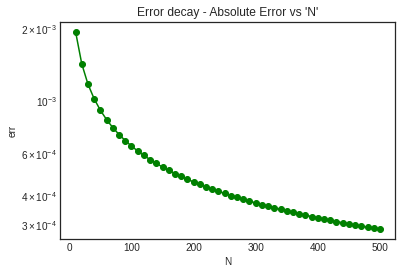

In [34]:
omega_new = [0,1]
f_new = lambda x : x*(1-x)

bc_new = [0,0]


fsol_an= lambda x : (pow(x,4)/12 - pow(x,3)/6 + x/12)



n_range = arange(10,501,10)

arr_error_approx=zeros(len(n_range))

for i,n_val in enumerate(n_range):
  x=linspace(0,1,n_val)
  A_new, b_new = finDif(omega_new, f_new, n_val, bc)
  HT_new, H_new = cholesky(A_new)
  y_new = L_solve(HT_new,b_new)
  u_app = U_solve(H_new,y_new)
  u_an = fsol_an(x)
  arr_error_approx[i] = linalg.norm(abs(u_an - u_app), 2)

#TABLE
Table_errors = pd.DataFrame({'N' : n_range, 'error' : arr_error_approx})  
display(Table_errors)

#PLOT
plt.title("Error decay - Absolute Error vs 'N'")
plt.xlabel('N')
plt.ylabel('err')
_ = plt.semilogy(n_range, error_approx, 'o-',color='green')

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [11]:
# Power Method Function 
def Power_Method(A,z0,tol,nmax):
    q = z0/(linalg.norm(z0,2))
    it = 0
    err = tol + 1.
    
    while it < nmax and err > tol:
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        q = z/linalg.norm(z,2)
        it += 1
    
    return l,q


In [12]:
# Inverse Power Method Function 
def I_Power_Method(A,x0,mu,tol,nmax):
    I = eye(len(A))
    M = A - mu*I
    L,U = LU(M)
    q = x0/linalg.norm(x0,2)
    err = tol + 1.0
    it = 0
    
    while it < nmax and err > tol:
        y = L_solve(L,q)
        x = U_solve(U,y)
        q = x/linalg.norm(x,2)
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        it += 1
    return l,q 

In [13]:
#CONDITION NUMBER 
def condNumb(A):
    z0 = random.rand(A.shape[0])
    mu = 0.0
    tol = 1.e-6
    nmax = 10000
    lmax = Power_Method(A,z0,tol,nmax)[0]
    #print(lmax)
    lmin = I_Power_Method(A,z0,mu,tol,nmax)[0]
    condNu = lmax/lmin
    
    return condNu

print(condNumb(A))
print(linalg.cond(A))

5294.59801445038
5294.598016140671


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

Precision achieved. Iterations: 50


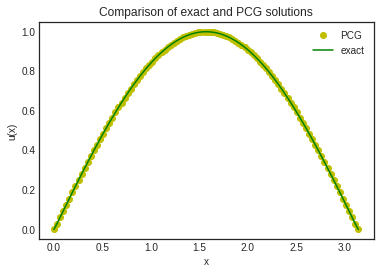

Difference between the PCG sol and the LU sol:
7.144872527823964e-14
Difference between the PCG sol and the Scipy sol:
6.551409247055097e-14


In [32]:
def PCG(A, b, P, nmax=len(A), eps=1e-10):
 
    tol = eps + 0.1
    iter = 0
    x = zeros_like(b)
    residual = b - dot(A,x)
    rho_old = 1.
    p_old = zeros_like(b)
    while (iter < nmax and tol > eps):
        iter += 1
        z = linalg.solve(P,residual)
        rho = dot(residual,z)
        if (iter > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/(dot(p,q))
        x += p*alpha
        residual -= q*alpha
        p_old = p
        rho_old = rho
        tol = linalg.norm(residual,2)  

    if iter <nmax:
        print('Precision achieved. Iterations:', iter)
    else:
        print('Convergence failed.')

    return x



x=linspace(omega[0],omega[1],n)
sol_conjugate_gradient = PCG(A,b,identity(len(A)))

# Old solution
w = L_solve(L,b)
u = U_solve(U,w)

# Scipy solution

u_ex = scipy.linalg.solve(A, b)
# plot
plt.title('Comparison of exact and PCG solutions')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.plot(x,sol_conjugate_gradient,'yo', label='PCG')
plt.plot(x,u_ex,'g', label='exact')
plt.legend(loc='best')
plt.show()

print("Difference between the PCG sol and the LU sol:")
print(linalg.norm(sol_conjugate_gradient - u)/linalg.norm(u))

print("Difference between the PCG sol and the Scipy sol:")
print(linalg.norm(sol_conjugate_gradient-u_ex)/linalg.norm(u_ex))


Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


First, we discretize the time using the Forward Euler approximation for the first derivative with respect to $t$ : 
$$ \frac{∂ u}{∂ t} (x, t) \sim  \frac{u(x, t_{n+1} ) - u (x, t_n)}{h_t}$$
This allows us to rewrite the time-dependent solution of the PDE as:
$$ u(x, t_{n+1} ) = u (x, t_n) + h_t u_{xx} (x, t_n) + h_t \alpha (t_n) f (x) $$

Then, we adopt the finite difference scheme used in the first point for the spatial derivative:
$$u_{xx}(x_i,t) = \frac{-u(x_{i-2},t)+16u(x_{i-1}, t)-30u(x_i, t)+16u(x_{i+1}, t) -u (x_{i+2}, t)}{12h_x^2}$$
and substituting this in the previous expression, we obtain

$$ u(x_i, t_{n+1} ) = u (x_i, t_n) + h_t  \frac{-u(x_{i-2},t)+16u(x_{i-1}, t)-30u(x_i, t)+16u(x_{i+1}, t) -u (x_{i+2}, t)}{12h_x^2} + h_t \alpha (t_n) f (x_i) $$

that can be rewritten in a more useful form as:
$$ u(x_i, t_{n+1} ) =   h_t  \frac{-u(x_{i-2},t)+16u(x_{i-1}, t)+(-30 + 12 h_x^2/h_t) u(x_i, t)+16u(x_{i+1}, t) -u (x_{i+2}, t)}{12h_x^2} + h_t \alpha (t_n) f (x_i) $$ .

Initial condition: y(0)=0


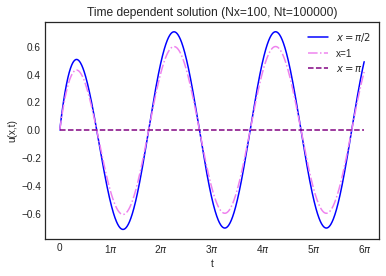

Initial condition: y(0)=sin(x)


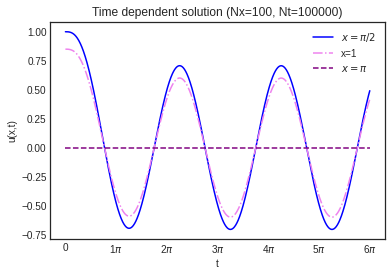

In [26]:
def Forward_Euler(u0, f, alpha, Omega_x, Omega_t, Nx, Nt):
    if not isinstance(u0, ndarray):
        u0 = u0*ones(Nx)
    
    ht = (Omega_t[1] - Omega_t[0]) / (Nt-1)
    hx = (Omega_x[1] - Omega_x[0]) / (Nx-1)
    
    xs = linspace(Omega_x[0],Omega_x[1], Nx)
    ts = linspace(Omega_t[0],Omega_t[1], Nt)

    #A = zeros((Nx,Nx), dtype=float)
 
    ood = -1.0*ones((Nx-2,))
    od  = 16*ones((Nx-1,))
    d   = (-30 + 12.0*pow(hx,2)/ht)*ones((Nx,))
    A   = (diag(ood,-2) + diag(od,-1) + diag(d,0) + diag(od,+1) + diag(ood,+2))
    A   = ht*A/(12.0*pow(hx,2))
    A[0,:]= 0
    A[-1,:]=0
    
    f = vectorize(f)(xs)
    
    u = zeros((Nx, Nt), dtype=float)
    u[:,0] = u0
    
    # boundary conditions
    u[[0,-1],0] = 0
    f[[0,-1]] = 0
    
    for i in range(1,Nt):
        u[:,i] = A.dot(u[:,i-1]) + ht * alpha(i*ht) * f
        
    return xs,ts,u




alpha_function = lambda x: cos(x)
f = lambda x: sin(x)

x_50, t_50, u_50 = Forward_Euler(0, f, alpha_function, (0,pi), (0,6*pi), Nx=50, Nt=100000)
x_1000, t_1000, u_1000 = Forward_Euler(0, f, alpha_function, (0,pi), (0,6*pi), Nx=1000, Nt=100000)



#time dependent solution solution at x=π/2, x=1, x=π

def plot_xfixed_solution(xs,ts,u,Nx,Nt):

    pi_2_idx = argmin(abs(xs - pi/2))
    one_idx = argmin(abs(xs - 1))
    pi_idx = -1
    
    approx_pi2 = round(xs[pi_2_idx],4)
    approx_one = round(xs[one_idx],4)
    approx_pi = round(xs[pi_idx], 4)

    time_slice = slice(None,None,100)

    
    plt.plot(ts[time_slice], u[pi_2_idx,time_slice], '-', color='blue', label=r'$x=\pi/2$' )
    plt.plot(ts[time_slice], u[one_idx,time_slice], '-.', color='violet', label='x=1')
    plt.plot(ts[time_slice], u[pi_idx,time_slice], '--', color='purple', label=r'$x=\pi$')

    plt.xticks([i*pi for i in range(7)], ['0', *('{}$\\pi$'.format(i) for i in range(1,7))])

    plt.xlabel('t')
    plt.ylabel('u(x,t)')

    plt.title('Time dependent solution (Nx={}, Nt={})'.format(Nx,Nt))
    plt.legend(loc='best')
    
print("Initial condition: y(0)=0")
x_100, t_100, u_100 = Forward_Euler(0, f, alpha_function, (0,pi), (0,6*pi), Nx=100, Nt=100000)
plt.figure(1)
plot_xfixed_solution(x_100, t_100, u_100, 100, 100000)
plt.show()

print("Initial condition: y(0)=sin(x)")

N_x=100
x=linspace(0,pi,N_x)

x_100, t_100, u_100 = Forward_Euler(sin(x), f, alpha_function, (0,pi), (0,6*pi), Nx=N_x, Nt=100000)

plt.figure(2)
plot_xfixed_solution(x_100, t_100, u_100, 100, 100000)
plt.show()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [16]:
def eigenvalues_LU(A,tol,Nmax_iterations=2000):
    B = A.copy()
    eigval_old = diag(B)
    err = tol+1.0
    it = 0
    
    while it < Nmax_iterations and err > tol:
        L,U = LU(B)
        B = matmul(U,L)
        eigval_new = diag(B)  
        err = linalg.norm(eigval_new - eigval_old,2)
        it += 1
        eigval_old = eigval_new
        
    return eigval_new

def eigenvectors_LU(A,tol,nmax):
    """
    this function estimates the eigenvectors of the matrix A
    using the Inverse Power Method with shift, and exploiting 
    the LU decomposition of A for the estimation of the eigenvalues.
    """

    eigvecs = zeros_like(A)
    n=A.shape[0]
    q = random.rand(n)
    eigvals = eigenvalues_LU(A,tol,1000)
    new_eigvals = zeros(len(eigvals))
    for i in range(len(eigvals)):
        eigval_val, eigvec_val = I_Power_Method(A,q,eigvals[i]+tol,tol,nmax)
        new_eigvals[i] = eigval_val
        eigvecs[i,:] = eigvec_val
         
    return new_eigvals, eigvecs

nmax = 10000
tol = 1e-10
eigenvalues=eigenvalues_LU(A,tol,1000)
shifted_eigenvalues, eigenvectors = eigenvectors_LU(A,tol,nmax)

eigenvalues_numpy,eigenvectors_numpy = linalg.eig(A)

diff_lambda= sort(shifted_eigenvalues)-sort(eigenvalues_numpy)

#print(diff_lambda)

print('max discrepancy lambda:', max(diff_lambda))

max discrepancy lambda: 1.318767317570746e-11


Compute the inverse of the matrix A exploiting the derived LU factorization

In [30]:
from scipy.linalg import solve

#estimation of the inverse of matrix A, using the LU decomposition
I = identity(n)
Y= solve(L,I,lower=True)
A_inv_LU = solve(U,Y)

#estimation of the inverse using Numpy
A_inv_numpy = linalg.inv(A)

print("Max difference between the numpy inverse and our estimated inverse matrix : ")
print(max(abs(A_inv_LU - A_inv_numpy).max(axis=0)))


#print(A_inverse)


Max difference between the numpy inverse and our estimated inverse matrix : 
2.813721478034381e-15


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

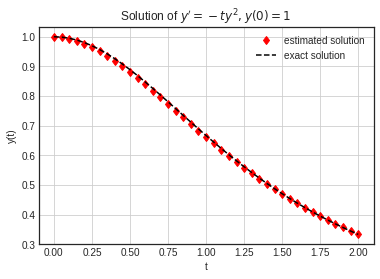

In [33]:
# Newton's Method function
def Newton(f,f_prime,x0,eps,nmax):
    assert abs(f_prime(x0)) > 1e-16
    err = abs(f(x0))
    errors = [err]
    it = 0
    x = x0
    
    while (err > eps and it < nmax):
        qk = f_prime(x)
        if abs(qk) < 1e-12:
            raise RuntimeError("f_prime(x) is close to zero")
        
        x_new = x - f(x)/qk 
        err = abs(f(x_new))
        
        x = x_new
        errors.append(err)
        it += 1
            
        #plt.semilogy(errors)

    return x, errors

# Backward Euler Method function
def B_Euler(y0,t0,tf,h):
    t_arr = arange(t0, tf+1e-10, h) #timesteps
    t = t_arr
    sol = zeros_like(t_arr)
    sol[0] = y0
    eps = 1e-5
    n_max = 1000
    
    for i in range(1, len(sol)):
        f = lambda y: t[i]*h*y**2 + y - sol[i-1]
        df = lambda y: 2*t[i]*h*y + 1
        sol[i],_ = Newton(f, df, sol[i-1], eps, n_max)

    return sol, t_arr

# Plot solution of Cauchy Problem

t_0 = 0.0
t_f = 2.0
y0 = 1.0

y,t = B_Euler(y0, t_0, t_f, 0.05)
y_ex = 2.0/(t*t + 2.0)

plt.title("Solution of $y'=-ty^2 , y(0)=1$" )
plt.grid(True)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.plot(t, y, 'rd', label='estimated solution')
plt.plot(t, y_ex, linestyle='dashed', color='black', label='exact solution')
plt.legend()
plt.show()